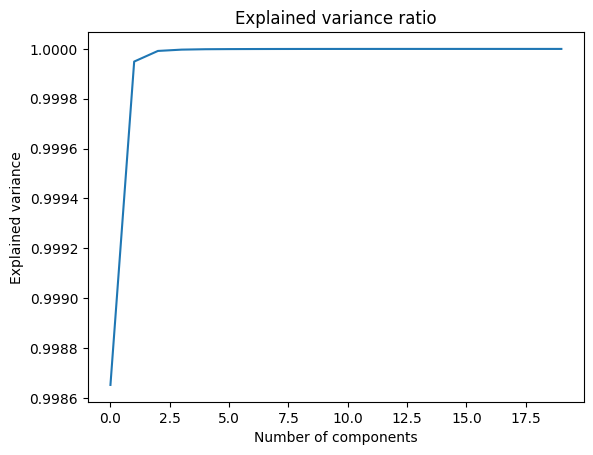

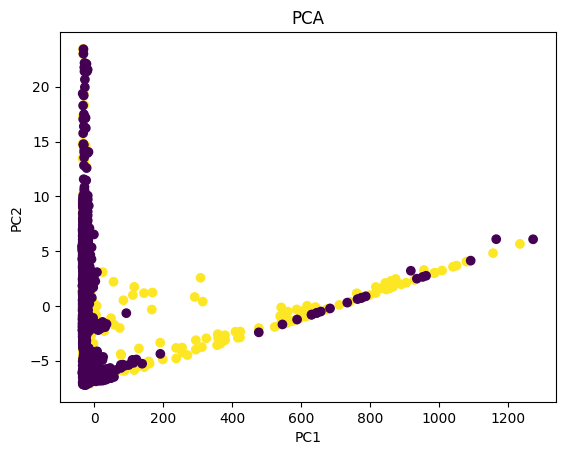

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       316
           1       0.98      0.97      0.97       318

    accuracy                           0.97       634
   macro avg       0.97      0.97      0.97       634
weighted avg       0.97      0.97      0.97       634

[[309   7]
 [  9 309]]


In [2]:
# zbiór danych ‘voice_extracted_features.csv’. Przeprowadź
# na nim analizę z zastosowaniem PCA:
# 1. podziel zbiór na podzbiory,
# 2. wygeneruj wykres punktowy pozostawiając 2 składowe główne, etykiety klas zastosuj
# do oznaczenia kolorów punktów odpowiadających poszczególnym obserwacjom,
# 3. zbuduj wykres procentu wyjaśnionej wariancji, dobierz optymalną liczbę cech dla progu
# 95%,
# 4. przeprowadź klasyfikację tworząc własny obiekt typu Pipeline.

import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Wczytanie danych
data = pd.read_csv('voice_extracted_features.csv')
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Konwersja etykiet na wartości numeryczne
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# PCA
pca = PCA()
pca.fit(X_train)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Explained variance ratio')
plt.show()

# PCA z 95% wyjaśnionej wariancji
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Wykres punktowy
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA')
plt.show()

# Klasyfikacja
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('classifier', RandomForestClassifier())
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))



In [3]:
# Przeprowadź 30 cykli uczenia-testowania dla danych z załadowanego zbioru danych.
# Przetestuj algorytmy kNN, SVM oraz Decision Tree. Dla każdego cyklu testowania wygeneruj
# macierz pomyłek. Uśrednij macierze, pomyśl, jaką płeć metody wykrywają łatwiej? Uzasadnij
# odpowiedź. Podpowiedź: spróbuj znaleźć uzasadnienie w macierzy pomyłek.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Inicjalizacja macierzy pomyłek
confusion_matrix_knn = np.zeros((2, 2))
confusion_matrix_svm = np.zeros((2, 2))
confusion_matrix_dt = np.zeros((2, 2))

# 30 cykli uczenia-testowania
for i in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # kNN
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('classifier', KNeighborsClassifier())
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    confusion_matrix_knn += confusion_matrix(y_test, y_pred)

    # SVM
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('classifier', SVC())
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    confusion_matrix_svm += confusion_matrix(y_test, y_pred)

    # Decision Tree
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),
        ('classifier', DecisionTreeClassifier())
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    confusion_matrix_dt += confusion_matrix(y_test, y_pred)
    
# Uśrednienie macierzy pomyłek
confusion_matrix_knn /= 30
confusion_matrix_svm /= 30
confusion_matrix_dt /= 30

print('KNN')
print(confusion_matrix_knn)
print('SVM')
print(confusion_matrix_svm)
print('Decision Tree')
print(confusion_matrix_dt)

# W macierzy pomyłek dla kobiety (klasa 0) widać, że kNN i Decision Tree mają problem z klasyfikacją mężczyzn (klasa 1).

KNN
[[302.4         14.06666667]
 [  7.06666667 310.46666667]]
SVM
[[308.8          7.66666667]
 [  7.1        310.43333333]]
Decision Tree
[[293.4         23.06666667]
 [ 21.03333333 296.5       ]]


In [6]:
# Napisz klasę, której obiekt może być dołączony do obiektu typu Pipeline. Niech ta klasa
# pozwala na dobór liczby cech na podstawie procentu wyjaśnionej wariancji. Podpowiedź: aby
# obiekt klasy można było dołączyć do Pipeline’u, musi on mieć takie metody, jak: ‘fit(x)’,
# ‘transform(x)’, ‘fit_transform(x)’.

class PCANComponentsSelector:
    def __init__(self, threshold):
        self.pca = PCA()
        self.threshold = threshold

    def fit(self, X, y=None):
        self.pca.fit(X)
        self.n_components = np.argmax(self.pca.explained_variance_ratio_.cumsum() >= self.threshold) + 1

    def transform(self, X):
        return self.pca.transform(X)[:, :self.n_components]

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

# Test klasy
pca = PCANComponentsSelector(0.95)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCANComponentsSelector(0.95)),
    ('classifier', RandomForestClassifier())
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


(3168, 1)
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       311
           1       0.97      0.97      0.97       323

    accuracy                           0.97       634
   macro avg       0.97      0.97      0.97       634
weighted avg       0.97      0.97      0.97       634

[[301  10]
 [  9 314]]


In [9]:
# Napisz klasę, której obiekt może być dołączony do obiektu typu Pipeline. Ta klasa ma
# zapewniać znalezienie wartości odstających oraz ich eliminację poprzez zastąpienie średnią.

class OutliersEliminator:
    def __init__(self, threshold):
        self.threshold = threshold

    def fit(self, X, y=None):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)

    def transform(self, X):
        return np.where(np.abs(X - self.mean) > self.threshold * self.std, self.mean, X)

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
    
# Test klasy
outliers_eliminator = OutliersEliminator(3)
X_outliers_eliminated = outliers_eliminator.fit_transform(X)
# print(X_outliers_eliminated)

pipeline = Pipeline([
    ('outliers_eliminator', OutliersEliminator(3)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('classifier', RandomForestClassifier())
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.97      0.98       311
           1       0.98      0.98      0.98       323

    accuracy                           0.98       634
   macro avg       0.98      0.98      0.98       634
weighted avg       0.98      0.98      0.98       634

[[303   8]
 [  6 317]]
